#### **PROGRAMA QUE UTILIZA MACHING LEARNIN PARA CLASIFICAR LOS MANGOS MADUROS Y PODRIDOS**
---


Este programa ilustra el uso de las librerías skimage, pathlib, numpy y matplotlib, para cargar un dataset de imagenes, inspeccionar datos, graficar y corregir errores. El conjunto de datos tomado para este trabajo es de: https://www.kaggle.com/datasets/adrinbd/unripe-ripe-rotten-mango

Este conjunto de datos cuenta con una clasificacion de 3 estados del mango, maduro(ripe), inmaduro(unripe) y podrido(rotten) con sus respectivas imagenes para el entrenamiento del modelo, de este conjunto de datos solo se tendran en cuenta los estados maduros y podridos, se trabajara con las mascaras de los mangos, el proceso para obtener estas mascaras no se tendra en cuneta en este trabajo.

El objetivo de estos conjuntos de imagenes es ser capas de difinir si un mango esta maduro(ripe) o podrido(rotten), usando ese conjunto de imagenes para entrenar este modelo.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from pathlib import Path
import os

from skimage.data import page
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
import skimage.io as io
from skimage.transform import resize
from skimage.feature import graycomatrix, graycoprops
import skimage.exposure as ske

import pandas as pd
import numpy as np
import skimage as ski
import statistics


from scipy.ndimage import binary_fill_holes
from sklearn.preprocessing import MinMaxScaler
from skimage.morphology import remove_small_objects

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn import metrics


from sklearn.metrics import classification_report
from sklearn import tree

import warnings

Se creara la función **obtener_imagenes()**, la cual retornara una lista donde cada elemento de la lista contendra un vector de cuatro posiciones con el nombre de la imagen, la imagen a color, la imagen en escala de grises y dejara una posicion disponible para la mascara de cada imagen, dichas mascaras estan en otra carpeta y se agregaran por medio de otra funcion.
* [["nombre_imagen_0",imagenen_0_formato_uint8,imagenen_0_escala_grises,""],
*    ...
* ["nombre_imagen_k",imagenen_k_formato_uint8,imagenen_k_escala_grises,""]]

In [2]:
def obtener_imagenes(ruta_carpeta):
    imagenes = []
    cont = 0
    for archivo in os.listdir(ruta_carpeta):
        try:
            img = ski.io.imread(ruta_carpeta+"/"+archivo)
            img = ski.util.img_as_ubyte(img)
            gray_image = rgb2gray(img)
            
            imagenes.append([archivo,img,gray_image, ""])
        except Exception as e:
            cont = cont + 1

    return imagenes

La funcion **obtener_mask()**, recibe como parametro la ruta en la que se encuentran las mascaras y la lista que contiene las imagenes con sus nombres, imagen, imagen en escala de grises y el espacion donde se almacenara la mascara correspondiente, 
* Cabe aclarar que las mascaras tienen el mismo nombre que la imagen original agregando mark_ripe o mark_rotten, ejemplo:
    * imagen a color: "img0.jpg"
    * mascara de la imagen: "img0_mask_mask_ripe.npy"

para comparar los nombre solo se necesita en el caso de la imagen a color lo que esta antes del punto, y para la mascara lo que esta antes del guion bajo, comparando esa palabra se sabra que la mascara pertenecen a esa misma imagen.
* Algunas mascaras estan en 3 canales por un error en el guardado, como las mascaras se aplicaran a la imagenes en escala de grises que solo tienen 1 canal, estas mascaras se le eliminara esos canales para que la mascara se aplicable a las imagenes en escala de grises.
* Para mayor efectividad en el modelo de clasificacion, a todas las imagenes en escala de grises y mascaras se les reajustaran las dimensiones para que coincida con (224,224).
* La mascara se guardara en el espacio que se dejo disponible en la lista.
* Se retorna la nueva lista.


In [3]:
def obtener_mask(ruta_carpeta, coleccion):
    imagenes = []
    carpeta = os.listdir(ruta_carpeta)
    for i in coleccion:
        nombre_img = obtener_primera_palabra(i[0],".")
       
        for archivo in carpeta:
            nombre_mask = obtener_primera_palabra(archivo,"_")
            if nombre_img == nombre_mask:
                mask = np.load(ruta_carpeta+"/"+archivo) 
                if len(mask.shape) == 3:
                    mask=mask[:,:,1]
                if mask.shape == i[2].shape:
                    if mask.shape != (224, 224):
                        i[2] = resize(i[2], (224, 224))
                        mask = resize(mask, (224, 224), preserve_range=True)
                    i[3] = mask
                    imagenes.append(i)
                break

    return imagenes

La funcion **obtener_primera_palabra()**, recibe una cadena de texto por parametro,  permite obtener la palabra que aparece antes del caracter que tambien recibe por parametro.

In [4]:
def obtener_primera_palabra(palabra, caracter):
    p = palabra.split(caracter)
    return p[0]

La funcion **hist2features(grayImg, mangoMask, figsize=(6, 4))**, permitira visualizar las imagenes mostrando una comparacion entre la imagen a escala de grises y la imagen a escala de grises con la mascara.

In [5]:
def hist2features(grayImg, mangoMask, figsize=(6, 4)):
    
    gray = ski.util.img_as_ubyte(grayImg)
    masked_gray = gray * mangoMask
    
    # Create a subplot figure with two columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)  # Adjust figsize as needed
    
    # Display the grayscale image on the first subplot
    ax1.imshow(gray, cmap='gray')
    ax1.set_title('Imagen en escala de grises')
    ax1.grid(False)
    
    # Display the masked grayscale image on the second subplot
    ax2.imshow(masked_gray, cmap='gray')
    ax2.set_title('Mascara de la imagen en escala de grises')
    ax2.grid(False)
    
    
    # Display the combined figure
    plt.show()
    #df_intensities = intensity_table(masked_gray)
    #print(df_intensities)
    #return df_intensities

Obtenemos las imagenes para los mango ripe y para los mangos rotten.

In [6]:
ripe = obtener_imagenes("./ripe")
rotten = obtener_imagenes("./rotten")

Obtenemos la mascara respectiva de cada imagen almacenada en las listas ripe y rotten

In [7]:
ripe = obtener_mask("./ripe_masks",ripe)
rotten = obtener_mask("./rotten_masks",rotten)

Escogemos una imgen de prueba para visualizar como se verian las imagen en escala de grises y como se veria en escala de grises con su mascara.

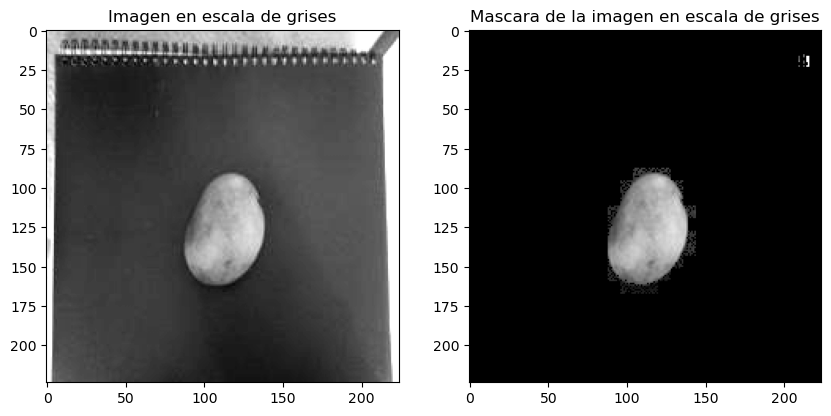

In [8]:
i =18
imagen_prueba = ripe[i]
hist2features(imagen_prueba[2] ,imagen_prueba[3],figsize=(10, 5))

Se puede notar que la en la imagen con la mascara, que en la esquina superior derecha hay unos cuantos pixeles que representan un area diferente a la del mango, como nuestro interes, es solo el mango, entonces abra que corregir la mascara para que solo tenga en cuenta el area mas grande que deberia ser el area que tiene el mango.

La funcion **obtener_mascara_area_mayor(mask_img)**:
* Recibe la mascara.
* Obtiene sus propiedades.
* Usando la propiedad area, obtiene el indice de el area mas grande.
* crea una nueva mascara solo con el area mas grande y la retorna.

In [9]:
def obtener_mascara_area_mayor(mask_img):
    
    labeled_img, count = ski.measure.label(mask_img, connectivity=2, return_num=True)
    # Obtener las propiedades de cada región
    props = ski.measure.regionprops(labeled_img)

    # Encontrar el índice del objeto con el área máxima
    areas = [prop.area for prop in props]
    max_area_index = np.argmax(areas)

    # Crear una nueva máscara para el objeto más grande
    largest_blob_label = max_area_index + 1  # Los índices comienzan desde 1
    largest_blob_mask = labeled_img == largest_blob_label

    return largest_blob_mask

La funcion **corregir_mascaras(lista)**, se encarga de aplicar la funcion **obtener_mascara_area_mayor(mask_img)** a cada mascara de la lista de mangos, teniendo en cuenta que cada elemento de la lista es una lista de 4 posiciones, y la cuarta posicion (3), es la que contiene la mascara.

In [10]:
def corregir_mascaras(lista):
    for i in lista:
        i[3] = obtener_mascara_area_mayor(i[3])

Se aplica **corregir_mascaras(lista)** a la lista ripe y la lista rotten.

In [11]:
corregir_mascaras(ripe)
corregir_mascaras(rotten)

Visulaizamos nuevamente la imagen anterior para verificar que el ruido generado por la mascara fue eliminado.

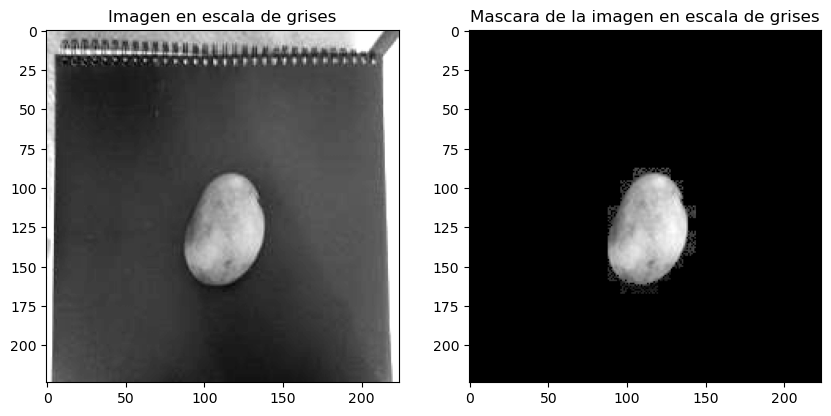

In [12]:
i =18
imagen_prueba = ripe[i]
hist2features(imagen_prueba[2] ,imagen_prueba[3],figsize=(10, 5))

Se puede observar que el ruido se que veia en la primera prueba ya no se encuentra en esta, por lo tanto la mascara fue corregida.

La funcion **std_image()** permite obtener la desviacion estandar del mango, sabiendo que:
* Una desviación estándar baja indica que los valores de los píxeles son muy similares, lo que sugiere una textura homogénea.
* Una desviación estándar alta indica que los valores de los píxeles varían considerablemente, lo que sugiere una textura más heterogénea.

In [13]:
def std_image(gray_img, mango_mask):
    
    idx_list = np.where(mango_mask == 1)
    mangoPixel_values = gray_img[idx_list]
    stdev = statistics.stdev(mangoPixel_values)
    return stdev

La funcion **caracteristicas_textura(gray_img, mango_mask)**, permitira obtener variables de prediccion usando caracteristicas de la textura como:
* Contrast:
    * Mide la intensidad de los cambios locales de gris en una imagen.
    * En el caso de los mangos, un alto contraste puede indicar la presencia de manchas, lesiones o variaciones en la coloración de la piel, lo que podría ser útil para detectar enfermedades o identificar variedades con características distintivas.
* Homogeneity:
    * Mide la similaridad de los valores de gris en una vecindad.
    * Un valor alto de homogeneidad indica que los píxeles cercanos tienen valores de gris similares, lo que sugiere una textura más uniforme. En los mangos, esto podría ser útil para distinguir entre variedades con pieles lisas y aquellas con pieles rugosas.
* Energy:
    * También conocida como uniformidad, mide la frecuencia con la que ocurre un par de niveles de gris en una vecindad.
    * Un valor alto de energía indica que la textura es muy regular y uniforme. En el caso de los mangos, podría ser útil para identificar variedades con una textura muy homogénea en la piel.
* Correlation:
    * Mide la relación lineal entre los valores de gris de los píxeles en una vecindad.
    * Un valor alto de correlación indica que los píxeles cercanos tienen una fuerte relación lineal, lo que sugiere una textura más ordenada. En los mangos, esta característica podría ser útil para distinguir entre variedades con diferentes patrones de venas o fibras en la piel.

In [14]:
def caracteristicas_textura(gray_img, mango_mask):
    
    
    gray = ski.util.img_as_ubyte(gray_img) 
    # Obtener la imagen dentro de la región de interés usando la máscara como índice booleano
    #masked_img = gray*mango_mask
    idx_list = np.where(mango_mask == 1)
    mangoPixel_values = gray_img[idx_list]
    
    mango_img = np.zeros_like(gray_img)
    mango_img[idx_list] = mangoPixel_values
    mango_img = ski.util.img_as_ubyte(mango_img)
    
    # Definir los parámetros de la GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    # Calcular la GLCM
    glcm = graycomatrix(mango_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Calcular las características
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    return [contrast, homogeneity, energy, correlation]

Creamos la **funcion extract_properties()**, para extraer la variables de prediccion que se usaran para el modelo de clasificacion y almacenarlas en un dataframe, ademas de las variables ya mencionadas se obtendran las variables:
* Area
    * Representa el número total de píxeles que componen una región de interés en la imagen.
    * Permite discriminar entre mangos de diferentes tamaños.
* Max_gray_value
    * Representa el valor de gris más alto encontrado en la región de interés. En una escala de grises, los valores más altos corresponden a tonos más claros.
    * En algunas variedades de mango, el valor máximo de gris puede estar relacionado con el nivel de madurez. Por ejemplo, un mango muy maduro puede tener áreas con valores de gris más altos debido a cambios en la piel.
* Min_gray_value
    * Representa el valor de gris más bajo encontrado en la región de interés. Valores más bajos corresponden a tonos más oscuros.
    * Puede ayudar a identificar áreas dañadas o podridas, que suelen tener valores de gris más bajos.
* Mean_gray_value
    * Representa el valor de gris promedio de todos los píxeles en la región de interés.
    * El valor medio puede cambiar a medida que el mango madura debido a cambios en la coloración de la piel.

In [15]:
def extract_properties(gray_img, mango_mask):
    
    labeled_mango, count = ski.measure.label(mango_mask, connectivity=2, return_num=True)
    
    object_features = ski.measure.regionprops(labeled_mango)
    

    var_gris_props = ['area', 'intensity_max', 'intensity_min', 'intensity_mean']
    gris_props = ski.measure.regionprops_table(labeled_mango, gray_img, properties=var_gris_props)
        
    grayImg_stdev = std_image(gray_img, mango_mask)
    df_image = pd.DataFrame(gris_props)

    texturas = caracteristicas_textura(gray_img, mango_mask)
    
    df_image.rename(columns={'intensity_max': 'max_gray_value', 'intensity_min': 'min_gray_value', 'intensity_mean': 'mean_gray_value'}, inplace=True)
    
    df_image['std'] = grayImg_stdev 
    df_image['contrast'] = texturas[0] 
    df_image['homogeneity'] = texturas[1] 
    df_image['energy'] = texturas[2] 
    df_image['correlation'] = texturas[3] 
        
    return df_image

Se implementara una prueba en una imagen, para verificar las variables que se extraen de la imagen, se estara utilizando la imagen que se visualizo anteriormente, las variables a extraer seran:
* area
* max_gray_value
* min_gray_value
* mean_gray_value
* std
* contrast
* homogeneity
* energy
* correlation

In [16]:
df_ejemplo=extract_properties(imagen_prueba[2],imagen_prueba[3])
print(df_ejemplo)

     area  max_gray_value  min_gray_value  mean_gray_value       std  \
0  3213.0        0.896194        0.040048         0.579415  0.202859   

    contrast  homogeneity    energy  correlation  
0  48.929372     0.940991  0.930915     0.983531  


como se puede ver en la tabla de el dataframe anterior, la funcion **extract_properties()** esta obteniendo las caracteristicas que necesitamos para este modelo, ahora se tiene que hacer los mismo para cada imagen de cada lista.

para esto se usara la funcion **obtener_data_frame_imagenes()**, la cual recibira la lista de imagenes que se crea de los respectivos tipos de mangos y a partir de ella crea un dataframe con las caracteristicas seleccionadas de cada imagen de mango.

In [17]:
def obtener_data_frame_imagenes(lista_imagenes):
    df = extract_properties(lista_imagenes[0][2],lista_imagenes[0][3])
    
    for imagen in lista_imagenes[1:]:
        df_ciclo = extract_properties(imagen[2],imagen[3])
        df =  pd.concat([df, df_ciclo], ignore_index=True)
        
        
    return df

A continuacion se extraera el dataframe de los mangos ripe y se visualizaran los datos.

In [18]:
df_ripe = obtener_data_frame_imagenes(ripe)

In [19]:
print("cantidad de imagenes en la lista ripe:",len(ripe))
print("cantidad de imagenes en el dataframe df_ripe:",len(df_ripe))
print()
print(df_ripe)

cantidad de imagenes en la lista ripe: 294
cantidad de imagenes en el dataframe df_ripe: 294

        area  max_gray_value  min_gray_value  mean_gray_value       std  \
0     4560.0        0.657422        0.096415         0.445445  0.112032   
1     4082.0        0.675431        0.072455         0.408536  0.098385   
2     8716.0        0.671715        0.106655         0.475659  0.090359   
3     7399.0        0.615909        0.064277         0.363080  0.068544   
4     4539.0        0.593028        0.060416         0.363767  0.077084   
..       ...             ...             ...              ...       ...   
289  13767.0        0.764513        0.105748         0.396082  0.100864   
290   8045.0        0.602485        0.067388         0.387897  0.067281   
291   9706.0        0.652587        0.073274         0.377345  0.071148   
292  11870.0        0.728333        0.088693         0.398226  0.091571   
293  13666.0        0.682874        0.039722         0.419652  0.078251   

     

A continuacion se extraera el dataframe de los mangos rotten y se visualizaran los datos.

In [20]:
df_rotten = obtener_data_frame_imagenes(rotten)

In [21]:
print("cantidad de imagenes en la lista rotten:",len(rotten))
print("cantidad de imagenes en el dataframe df_rotten:",len(df_rotten))
print()
print(df_rotten)

cantidad de imagenes en la lista rotten: 540
cantidad de imagenes en el dataframe df_rotten: 540

        area  max_gray_value  min_gray_value  mean_gray_value       std  \
0    38239.0        0.895004        0.009167         0.434802  0.115524   
1    26817.0        1.000000        0.007843         0.559756  0.126476   
2    35125.0        0.788041        0.020611         0.582307  0.113931   
3    37395.0        0.952043        0.000565         0.688276  0.184825   
4    37697.0        0.978420        0.103941         0.400430  0.138710   
..       ...             ...             ...              ...       ...   
535  30213.0        1.000000        0.006667         0.372301  0.145326   
536  37362.0        0.941258        0.004167         0.553169  0.175546   
537  31724.0        0.897565        0.005833         0.411765  0.089855   
538  32777.0        1.000000        0.024167         0.517712  0.144118   
539  17131.0        1.000000        0.010878         0.458615  0.140138   

 

Como se puede observar en las extracciones de caracteristicas anterires, a todas las imagenes se les extrajo las caracteristicas sin encontrar errores o perder alguna imagen.

Para poder entrenar el modelo sera necesario tener el dataframe de mangos ripe y el dataframe de mangos rotten en uno solo, pero para ello sera necesaria una nueva caracteristica para identificar un mango ripe de un mango rotten, por lo tanto se creara la caracteristica **clase** con valores de **0** para **rotten** y **1** para **ripe**.
Como sabemos que las primera 294 filas del dataframe corresponde a los mangos ripe, entonces asignaremos a toda la columna **clase** el valor de **1**, y a partir del numero de filas en el dataframe **df_ripe**, tendran el valor de **0**.

In [22]:
df_mangos_combinado = pd.concat([df_ripe, df_rotten], ignore_index=True)
# Creamos una nueva columna 'clase' y asignamos los valores
df_mangos_combinado['clase'] = 1
df_mangos_combinado.loc[df_mangos_combinado.index >= len(df_ripe), 'clase'] = 0

In [23]:
print(df_mangos_combinado)

        area  max_gray_value  min_gray_value  mean_gray_value       std  \
0     4560.0        0.657422        0.096415         0.445445  0.112032   
1     4082.0        0.675431        0.072455         0.408536  0.098385   
2     8716.0        0.671715        0.106655         0.475659  0.090359   
3     7399.0        0.615909        0.064277         0.363080  0.068544   
4     4539.0        0.593028        0.060416         0.363767  0.077084   
..       ...             ...             ...              ...       ...   
829  30213.0        1.000000        0.006667         0.372301  0.145326   
830  37362.0        0.941258        0.004167         0.553169  0.175546   
831  31724.0        0.897565        0.005833         0.411765  0.089855   
832  32777.0        1.000000        0.024167         0.517712  0.144118   
833  17131.0        1.000000        0.010878         0.458615  0.140138   

        contrast  homogeneity    energy  correlation  clase  
0      66.739150     0.923026  0.9016

con los dataframe ya unidos, podemos ver aparntemente que todas las caracteristicas estan normalizadas con valores entre 0 y 1 a excepcio del area la cual sera normalizada para mejorar la efectividad del modelo. para verificar utilizamos la funcion **describe()**.

In [24]:
print(df_mangos_combinado.describe())

               area  max_gray_value  min_gray_value  mean_gray_value  \
count    834.000000      834.000000      834.000000       834.000000   
mean   11019.443645        0.787377        0.091927         0.463559   
std     8775.337093        0.131232        0.060861         0.137066   
min     2753.000000        0.534254        0.000000         0.187331   
25%     5979.500000        0.669839        0.042965         0.323070   
50%     8044.500000        0.782908        0.085811         0.481942   
75%    11532.750000        0.895571        0.132273         0.577785   
max    46888.000000        1.000000        0.300129         0.818749   

              std     contrast  homogeneity      energy  correlation  \
count  834.000000   834.000000   834.000000  834.000000   834.000000   
mean     0.137798   326.983166     0.827568    0.770627     0.906464   
std      0.032783   330.721424     0.120984    0.177306     0.079830   
min      0.064652    45.063941     0.288092    0.061322     0.5

Analizando esa descripcion es notable como en la variable area, los valores hasta el 75% son de 11532, pero cuando llega al valor maximo, este derepente se cuadruplica, esto indica que hay cierto numero de imagenes que tienen areas mucho mas grandes que las que se utilizanan en este modelo, y vemos que algo similar ocurre con la variable contast.

Crearemos una funcion llamada **grafica_barras(df_mangos)** que nos permita ver a trvez de una grafica de barras el tamaño de la muestra para los mangos ripe y los mangos rotten, a partir del dataframe que contien la clase de los mangos.

In [25]:
def grafica_barras(df_mangos):
    ax=plt.subplots(1,1,figsize=(10,8))
    sns.countplot(x='clase', data=df_mangos)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    
    # Personalizar el gráfico
    count_ripe = df_mangos['clase'].value_counts()[1]
    count_rotten = df_mangos['clase'].value_counts()[0]
    
    plt.text(1,count_ripe +2, str(count_ripe), ha='center')
    plt.text(0,count_rotten +2, str(count_rotten), ha='center')
    plt.title('Cantidad de imagenes Rotten VS Ripe')
    plt.ylabel('Cantidad')
    plt.xlabel('Estado')
    plt.show()

Crearemos una funcion llamada **histogramas(X)** que nos permita ver los datos que tenemos de cada caracteristica a trvez de una grafica de histogramas para cada caracteristica, este histograma se modifico para que permitiera ver el rango de valores que representa da barra del histograma.

In [26]:
def histogramas(X):
    ncols = 3  # Arrange 2 histograms per row
    
    # Iterate through columns in chunks
    for i in range(0, len(X.columns), ncols):
        # Create a subplot grid
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(11, 4))
    
        # Generate histograms for each column in the current chunk
        for j, column in enumerate(X.columns[i:i+ncols]):
            counts, bins, des = axes[j].hist(X[column], edgecolor='black', linewidth=1.2)
             # Create bin centers
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            # Create bin labels with ranges
            bin_labels = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins)-1)]
             # Get bar width
            bar_width = bins[1] - bins[0]  # Assuming uniform bin width
            # Add text annotations for bin labels within bars (manual placement)
            for i, (x, count, label) in enumerate(zip(bin_centers, counts, bin_labels)):
                axes[j].text(x, count /2 , label, ha='left', va='bottom',rotation=90, fontsize=10)  # Adjust y-offset for better visibility
            # Remove extra elements from plots (optional)
            axes[j].set_title(f"{column}")
            axes[j].grid(False)
    
            # Adjust layout (optional)
            axes[j].margins(x=0)  # Remove extra space on the sides
        # Fine-tune layout (optional)
        plt.tight_layout()  # Adjust spacing between subplots
        
        plt.show()

Crearemos una funcion llamada **grafica_caja(X)** que nos permita ver a traves de una grafica de caja los datos que tenemos.

In [27]:
def grafica_caja(X):
    #boxplot de las variables numericas
    box_data = X #variable representing the data array
    sns.boxplot(data = box_data,width=0.4,fliersize=5)
    plt.grid(False)
    plt.show()

In [28]:
def grafica_caja_multiple(lista_dfs, filas=None, columnas=None, fontsize_titulos=10, fontsize_etiquetas=8, rot=0):
    num_plots = len(lista_dfs)
    if filas is None and columnas is None:
        # Calcular filas y columnas automáticamente
        filas = int(np.ceil(np.sqrt(num_plots)))
        columnas = int(np.ceil(num_plots / filas))

    fig, axes = plt.subplots(filas, columnas, figsize=(12, 4*filas))

    for i, df in enumerate(lista_dfs):
        row, col = divmod(i, columnas)
        sns.boxplot(data=df, ax=axes[row, col])
        axes[row, col].set_title(f'DataFrame {i+1}', fontsize=fontsize_titulos)

        
        tick_positions = range(len(df.columns))
        axes[row, col].set_xticks(tick_positions)

        axes[row, col].set_xticklabels(df.columns, rotation=rot, fontsize=fontsize_etiquetas)
        axes[row, col].grid(False)

    plt.tight_layout()
    plt.show()

Crearemos una funcion llamada **mapa_de_calor(x)** que nor permitira ver el mapa de calor de las variables predictoras.

In [29]:
def mapa_de_calor(x):
    f, ax = plt.subplots(figsize=(10, 8))
    corr = x.corr(method='spearman')
    sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax, annot=True)
    plt.show() 

La funcion **normalizar(df_mangos)** nos permitira normarlizar todas las caracteristicas del dataframe.

In [30]:
#df_filtrado = df_mangos_combinado[df_mangos_combinado['area'] <= 15000]

def normalizar(df_mangos):
    scaler = MinMaxScaler()
    # Ajustar el scaler a los datos y transformarlos
    df_normalized = scaler.fit_transform(df_mangos)
    # Convertir el resultado a un DataFrame
    df_mangos_normalizado = pd.DataFrame(df_normalized, columns=df_mangos.columns)
    print(df_mangos_normalizado.describe())
    return df_mangos_normalizado

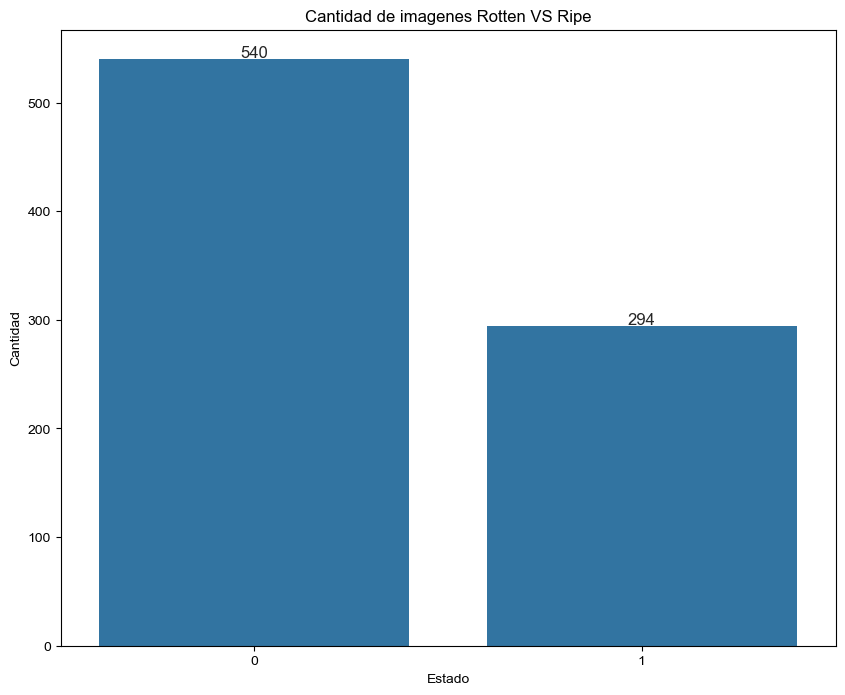

In [31]:
grafica_barras(df_mangos_combinado)

Como se ve en la grafica de barras anterior, la cantidad de imagenes de las clases, se encuentra desbalanceada a favor de los mangos rotten, teniendo este casi el doble de imagenes de los mangos ripe; pero como ambas clases contienen ejemplos, revisaremos también los histogramas de frecuencia para las variables predictoras de este ejemplo, las cuales también son todas de tipo numérico.

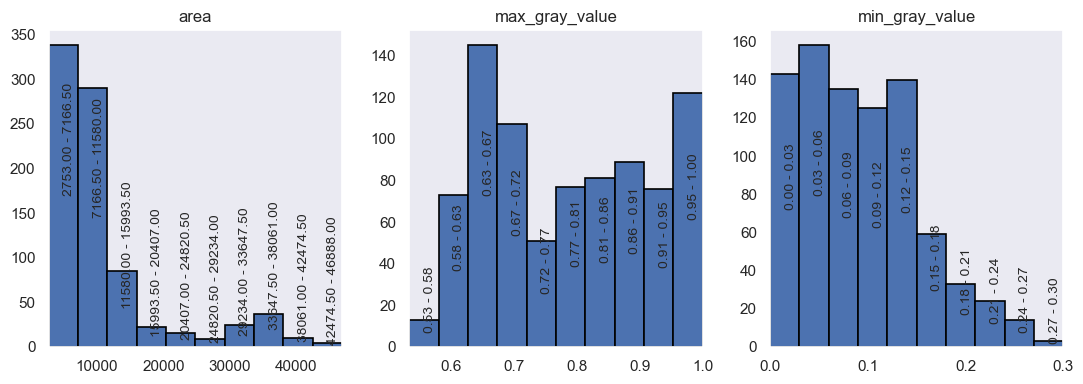

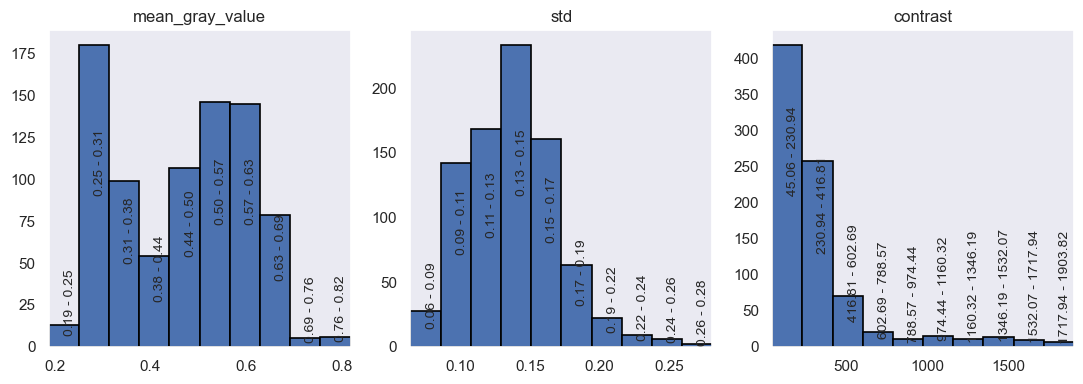

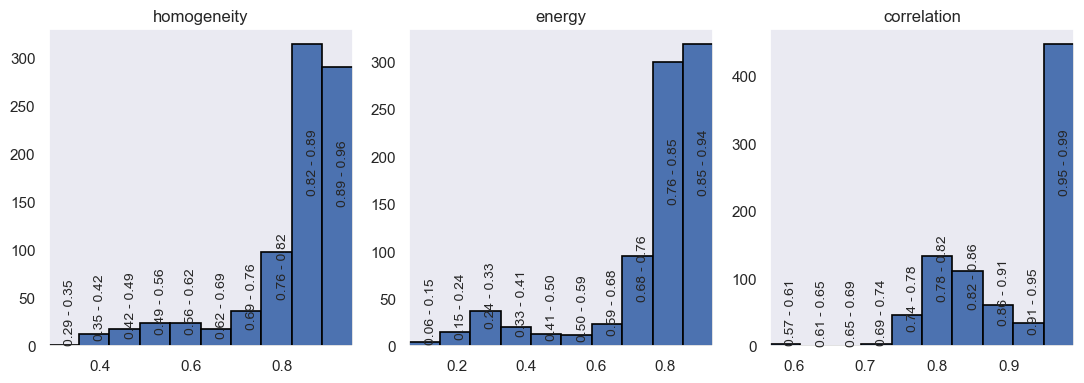

In [45]:
histogramas(df_mangos_combinado.drop(columns=['clase'], axis=1))

viendo los histogramas, se hace muy notorio que los histograma de **area** y **contrast** tienen una  distribución sesgada a la izquierda, y los histogramas de **homogeneity**, **energy** y correlacion tienen una  distribución sesgada a la derecha, esto podria ser a causa de datos atipicos en el dataframe, puesto que la cantidad de datos opuestos a la distribucion de estos histogramas, es muy pequeña.
para verificar esto, se usara la grafica de cajas, para analizar mejor los datos atipicos.

Normalizare el dataframe de los datos con la funcion **normalizar(df_mangos_combinado)**, para ver mejor el grafico de cajas.

In [33]:
df_normalizado = normalizar(df_mangos_combinado)

             area  max_gray_value  min_gray_value  mean_gray_value  \
count  834.000000      834.000000      834.000000       834.000000   
mean     0.187299        0.543480        0.306293         0.437472   
std      0.198829        0.281767        0.202782         0.217077   
min      0.000000        0.000000        0.000000         0.000000   
25%      0.073105        0.291113        0.143155         0.214974   
50%      0.119894        0.533884        0.285914         0.466586   
75%      0.198929        0.775782        0.440721         0.618377   
max      1.000000        1.000000        1.000000         1.000000   

              std    contrast  homogeneity      energy  correlation  \
count  834.000000  834.000000   834.000000  834.000000   834.000000   
mean     0.338844    0.151671     0.807637    0.806979     0.800411   
std      0.151863    0.177926     0.181123    0.201721     0.188274   
min      0.000000    0.000000     0.000000    0.000000     0.000000   
25%      0.228

Haremos 4 graficos de cajas para:
* diagrama de caja 1 Muestra el diagrama de cajas del dataframe de todos los datos.
* diagrama de caja 2 Muestra el diagrama de cajas del dataframe sin la caracteristica 'area'.
* diagrama de caja 3 Muestra el diagrama de cajas del dataframe sin la caracteristica 'area' y 'contrast'.
* diagrama de caja 4 Muestra el diagrama de cajas del dataframe con todas las caracteristicas normalizada.

In [34]:
df1= df_mangos_combinado.drop(columns=['clase'], axis=1)
df2= df_mangos_combinado.drop(columns=['clase','area'], axis=1)
df3= df_mangos_combinado.drop(columns=['clase','area','contrast'], axis=1)
df4= df_normalizado.drop(columns=['clase'], axis=1)

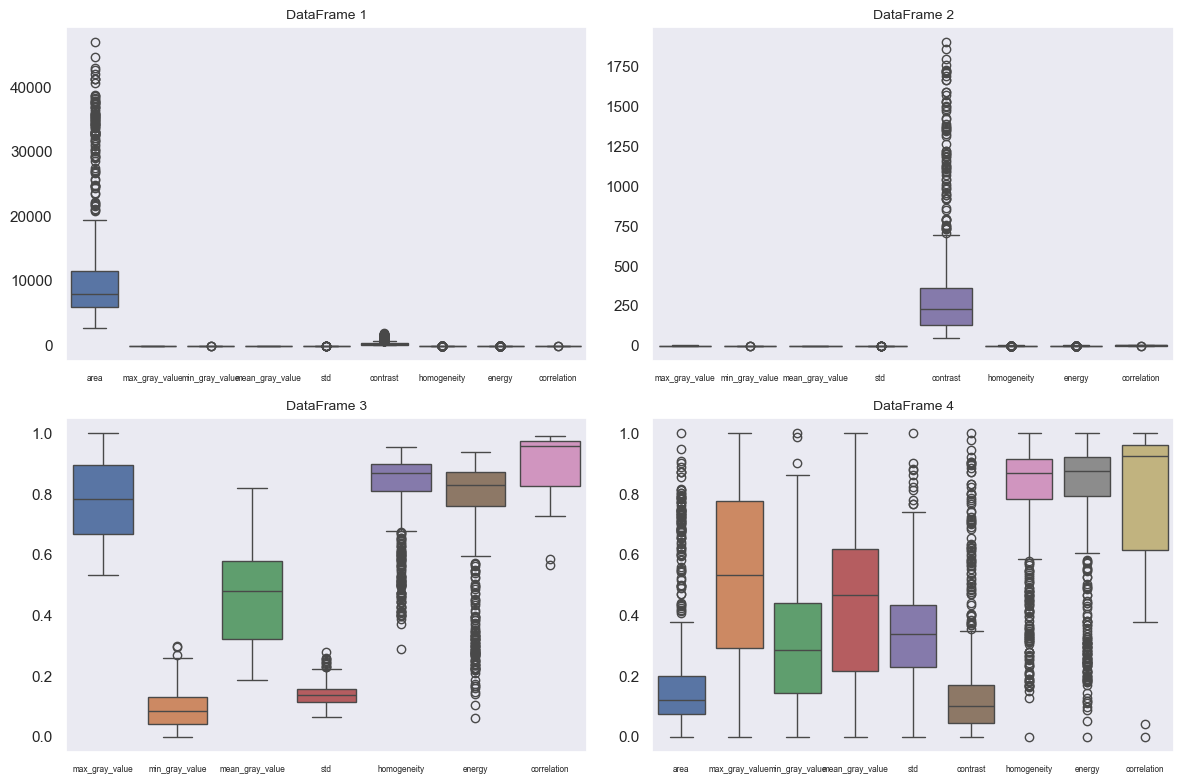

In [35]:
grafica_caja_multiple([df1,df2,df3,df4], fontsize_etiquetas=6)

Sin normalizar los datos es muy dificil analizar de forma adecuada los diagramas de cajas, en cambio, cuando fue normalizado facilita mucho mas el analisis.
podemos ver de forma mas clara lo mencionado anterior mente en los histogramas, puesto que en el diagrama de caja se puede ver de forma mas clara la cantidad de datos atipico en las variables **area**, **contrast**, **homogeneity** y **energy**.
esto nos lleva a tomar una desicion sobre los datos, o eliminar esos datos atipicos o eliminar esas variables, esta decision sera pospuesta para luego de ver el mapa de calor a ver que variables estan altamente correlacionadas.

Se mostrara el mapa de calor del dataframe para ver la correlacion.

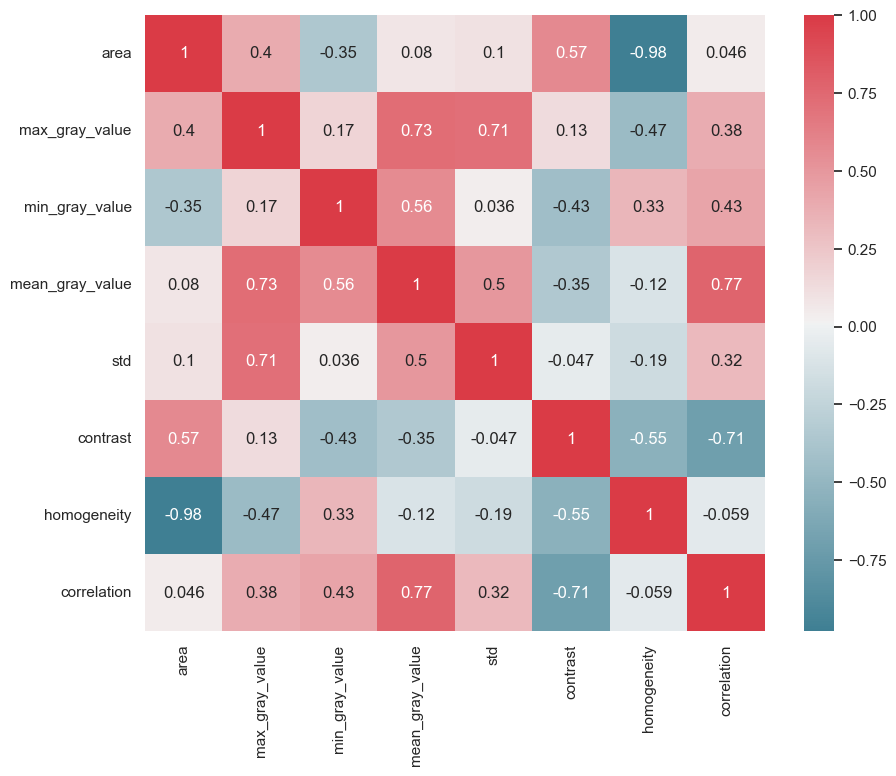

In [45]:
mapa_de_calor(df_mangos_combinado)

* Analizando el mapa de calor, es muy notorio la correlacion que hay entre **homogeneity** y **energy**, nos lleva a la decicion de elminar una de las dos variables, pero viendo que la corelacion entre la variable predictora **homogeneity** y la variable a predecir **clase**, es mayor a la corelacion entre la variable predictora **energy** y la variable a predecir **clase**, se toma la decicion de eliminar la variable **energy**.
* tambien se nota una alta correlacion  de **0,77** entre las variables de prediccion **correlation** y **mean_gray_value**, aunque esta correlacion no es decisiva para la eliminacion de alguna de estas variables.
* tambien se nota una alta correlacion de **0,73** entre las variables de prediccion **max_gray_value** y **mean_gray_value**, aunque esta correlacion no es decisiva para la eliminacion de alguna de estas variables.
* tambien se nota una alta correlacion de **0,71** entre las variables de prediccion **max_gray_value** y **std**, aunque esta correlacion no es decisiva para la eliminacion de alguna de estas variables.


Se elimina la variable de decicion **energy**.

In [41]:
df_mangos_combinado = df_mangos_combinado.drop(columns=['energy'])

In [42]:
df_normalizado = normalizar(df_mangos_combinado)

             area  max_gray_value  min_gray_value  mean_gray_value  \
count  834.000000      834.000000      834.000000       834.000000   
mean     0.187299        0.543480        0.306293         0.437472   
std      0.198829        0.281767        0.202782         0.217077   
min      0.000000        0.000000        0.000000         0.000000   
25%      0.073105        0.291113        0.143155         0.214974   
50%      0.119894        0.533884        0.285914         0.466586   
75%      0.198929        0.775782        0.440721         0.618377   
max      1.000000        1.000000        1.000000         1.000000   

              std    contrast  homogeneity  correlation  
count  834.000000  834.000000   834.000000   834.000000  
mean     0.338844    0.151671     0.807637     0.800411  
std      0.151863    0.177926     0.181123     0.188274  
min      0.000000    0.000000     0.000000     0.000000  
25%      0.228142    0.046229     0.783111     0.614952  
50%      0.337134    

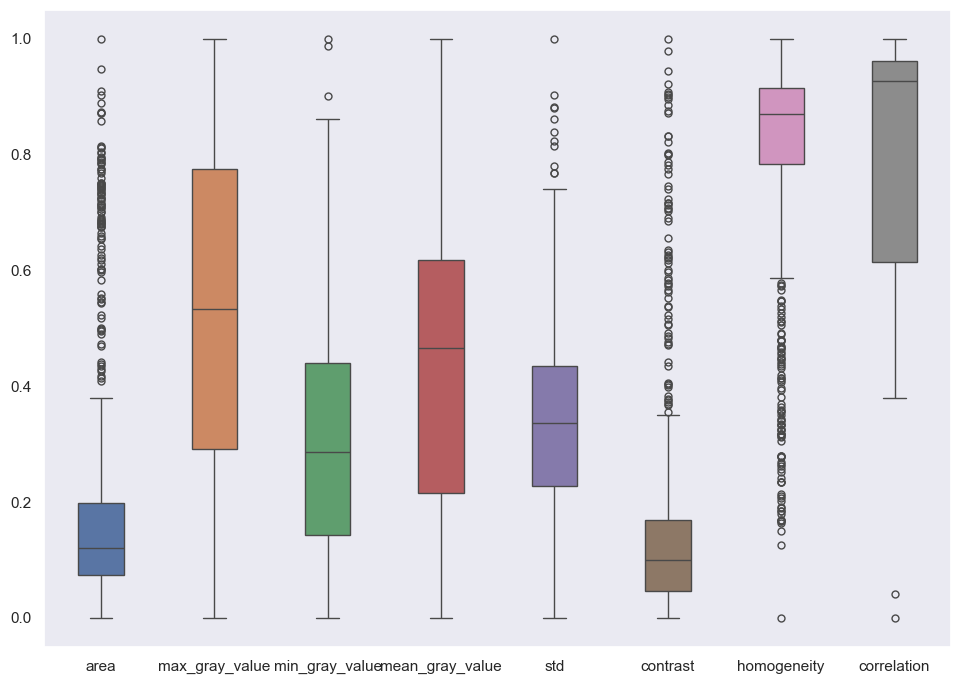

In [44]:
grafica_caja(df_normalizado.drop(columns=['energy']))

Ya solucionado el problema con las variables correlacionadas, nos enfrentamos nuevamente al problema de los valores atipicos que pueden limitar el modelo.

In [35]:
def index_datos_atipicos(df_mangos, column):
    
    count_ripe = df_mangos['clase'].value_counts()[1]
    
    # Calcular el primer y tercer cuartil
    Q1 = df_mangos[column].quantile(0.25)
    Q3 = df_mangos[column].quantile(0.75)
    
    # Calcular el rango intercuartílico (IQR)
    IQR = Q3 - Q1
    
    # Definir los límites para los valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #print(lower_bound)
    #print(upper_bound)
    
    
    # Remove outliers
    atipico_menor= [df_mangos[column] < lower_bound,df_mangos['clase']]
    atipico_mayor= [df_mangos[column] > upper_bound,df_mangos['clase']]
    
    
    cont = 0
    index_mayores = [[],[]]
    index_menores = [[],[]]

    
    for i in range(len(atipico_mayor[0])):
        #print(atipico_mayor[0][i])
        if atipico_mayor[0][i] == 1:
            if atipico_mayor[1][i]== 1:
                index_mayores[0].append(cont)
            else:
                index_mayores[1].append(cont-count_ripe)
        cont = cont + 1


    for j in range(len(atipico_menor[0])):
        if atipico_menor[0][j]== 1:
            if atipico_menor[1][j]== 1:
                index_menores[0].append(cont)
            else:
                index_menores[1].append(cont-count_ripe)
        cont = cont + 1

    return index_mayores, index_menores

In [127]:
_, index =index_datos_atipicos(df_mangos_combinado,'homogeneity')
print("index atipico de ripe",len(index[0]))
print("index atipico de rotten",len(index[1]))

index atipico de ripe 0
index atipico de rotten 8


In [113]:

for i in index[0]:
    imagen_prueba = ripe[i]
    hist2features(imagen_prueba[2] ,imagen_prueba[3])

In [128]:
for i in index[1]:
    imagen_prueba = rotten[i]
    print("mango con posicion", i)
    hist2features(imagen_prueba[2] ,imagen_prueba[3])

IndexError: list index out of range

In [129]:
for i in reversed(index[0]):
    ripe.pop(i)
for i in reversed(index[1]):
    rotten.pop(i)

IndexError: pop index out of range

In [130]:
index_df = index[0]
count_ripe = df_mangos_combinado['clase'].value_counts()[1]
for i in index[1]:
    index_df.append(i+count_ripe)

In [131]:
print(len(index_df))
mask = ~df_mangos_combinado.index.isin(index_df)

# Filtramos el DataFrame utilizando la máscara
df_mangos_combinado = df_mangos_combinado[mask]
df_mangos_combinado=df_mangos_combinado.reset_index(drop=True)
print(df_mangos_combinado)

8
        area  max_gray_value  min_gray_value  mean_gray_value       std  \
0     4560.0        0.657422        0.096415         0.445445  0.109356   
1     4082.0        0.675431        0.072455         0.408536  0.059950   
2     8716.0        0.671715        0.106655         0.475659  0.051623   
3     7399.0        0.615909        0.064277         0.363080  0.029186   
4     4539.0        0.593028        0.060416         0.363767  0.034500   
..       ...             ...             ...              ...       ...   
653   8120.0        0.994628        0.196634         0.560909  0.185287   
654  10062.0        0.965505        0.151250         0.598094  0.024832   
655  11755.0        0.939169        0.163274         0.611556  0.051405   
656   7607.0        0.892757        0.198025         0.597324  0.076287   
657  11953.0        0.833471        0.113304         0.561568  0.031956   

       contrast  homogeneity    energy  correlation  clase  
0     66.739150     0.923026  0.9016

In [181]:
df_mangos_normalizado = normalizar(df_mangos_combinado)

             area  max_gray_value  min_gray_value  mean_gray_value  \
count  658.000000      658.000000      658.000000       658.000000   
mean     0.411521        0.481735        0.389399         0.464521   
std      0.221484        0.258980        0.219801         0.296637   
min      0.000000        0.000000        0.000000         0.000000   
25%      0.251492        0.264453        0.206224         0.151406   
50%      0.381421        0.405495        0.380653         0.498105   
75%      0.543821        0.716625        0.526142         0.730694   
max      1.000000        1.000000        1.000000         1.000000   

              std    contrast  homogeneity      energy  correlation  \
count  658.000000  658.000000   658.000000  658.000000   658.000000   
mean     0.294467    0.352053     0.611087    0.588236     0.679327   
std      0.256579    0.228264     0.201040    0.219242     0.310904   
min      0.000000    0.000000     0.000000    0.000000     0.000000   
25%      0.087

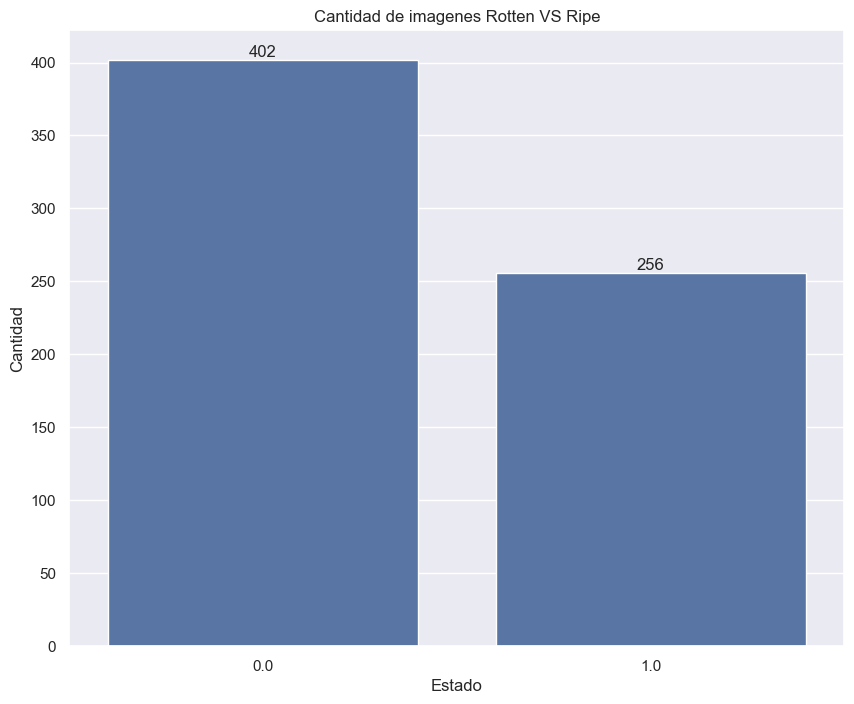

In [182]:
grafica_barras(df_mangos_normalizado)

In [183]:
X = df_mangos_normalizado.iloc[:, :-1]
y = df_mangos_normalizado['clase']

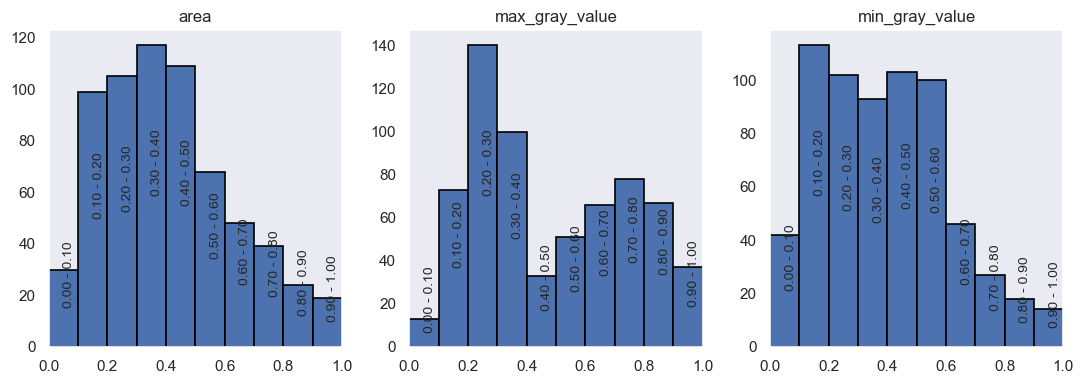

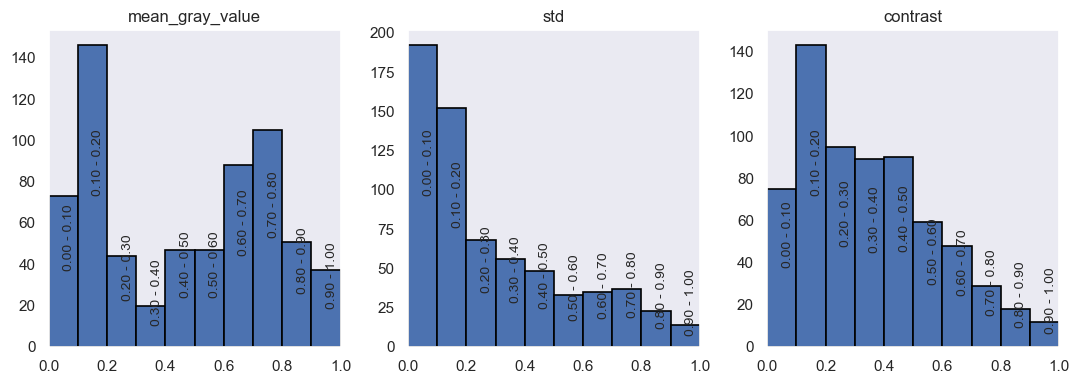

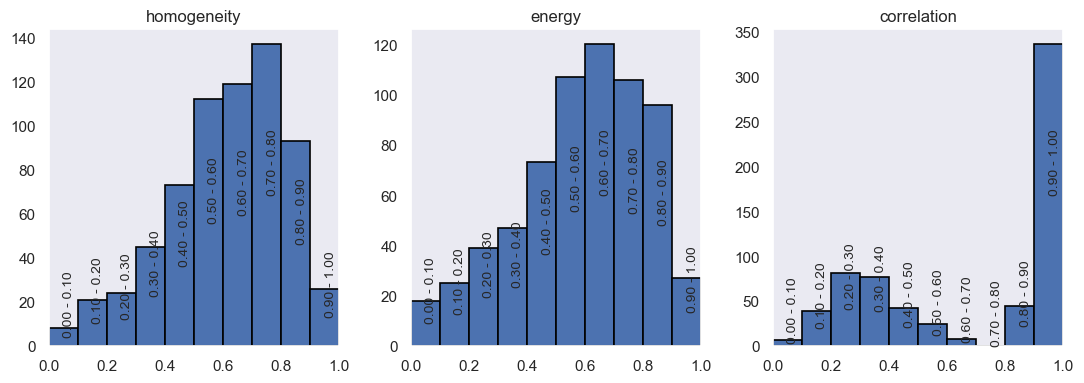

In [184]:
histogramas(X)

       area  max_gray_value  min_gray_value  mean_gray_value       std  \
0  0.151913        0.264453        0.372536         0.444874  0.378915   
1  0.111728        0.303120        0.279960         0.366926  0.172785   
2  0.501303        0.295141        0.412105         0.508683  0.138042   
3  0.390584        0.175322        0.248359         0.270927  0.044431   
4  0.150147        0.126193        0.233440         0.272377  0.066600   

   contrast  homogeneity    energy  correlation  
0  0.042932     0.844164  0.843318     0.923142  
1  0.036394     0.885325  0.879856     0.894721  
2  0.127106     0.537877  0.498580     0.940063  
3  0.504933     0.721466  0.607282     0.528369  
4  0.385834     0.888018  0.846671     0.423304  


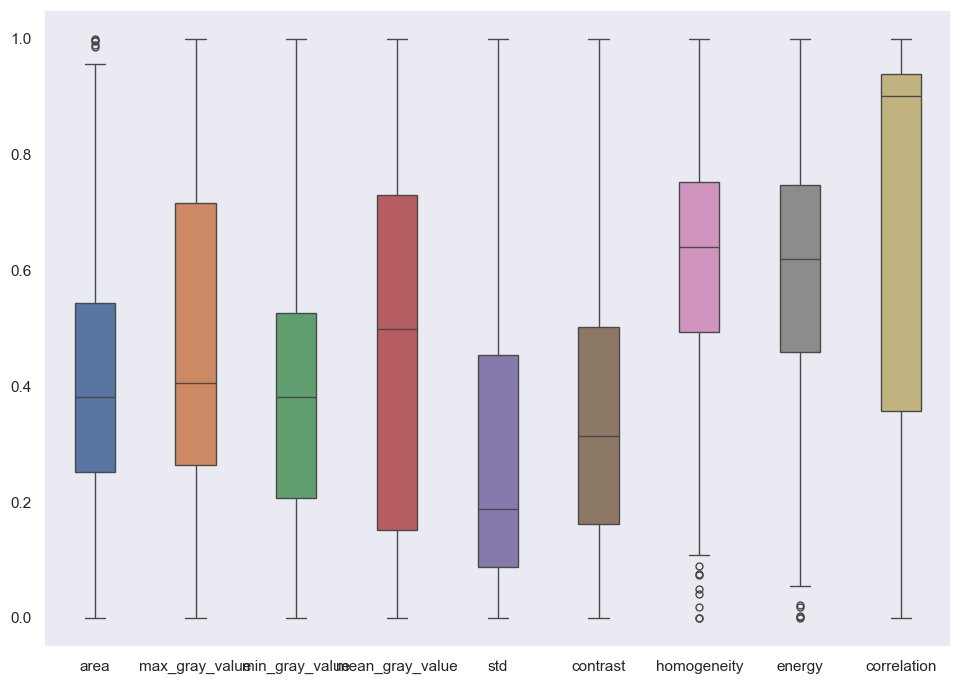

In [185]:
grafica_caja(X)

In [186]:
clase=pd.get_dummies(df_mangos_normalizado['clase'])
x=df_mangos_normalizado.drop('clase',axis=1) #Elimina la variable State de X, y se queda con las nuevas variables creadas por cada categoría
x=pd.concat([x,clase],axis=1)

print(x.head())

       area  max_gray_value  min_gray_value  mean_gray_value       std  \
0  0.151913        0.264453        0.372536         0.444874  0.378915   
1  0.111728        0.303120        0.279960         0.366926  0.172785   
2  0.501303        0.295141        0.412105         0.508683  0.138042   
3  0.390584        0.175322        0.248359         0.270927  0.044431   
4  0.150147        0.126193        0.233440         0.272377  0.066600   

   contrast  homogeneity    energy  correlation    0.0   1.0  
0  0.042932     0.844164  0.843318     0.923142  False  True  
1  0.036394     0.885325  0.879856     0.894721  False  True  
2  0.127106     0.537877  0.498580     0.940063  False  True  
3  0.504933     0.721466  0.607282     0.528369  False  True  
4  0.385834     0.888018  0.846671     0.423304  False  True  


como se puede ver, todos los valores ahora se encuentran normalizados entre cero y uno, a continuacion un histograma para verificar con cuantos datos contamos de los mangos ripe y rotten.

In [188]:
def corr_feature_detect(data, threshold):
     
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] # remove the digonal
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            # append the block of features to the list
            correlated_groups.append(correlated_block)
    return correlated_groups


In [189]:
corr = corr_feature_detect(data=x,threshold=0.95)
for i in corr:
    print(i,'\n')
if len(corr) == 0:
    print('No hay variables correlacionadas')

  feature1     feature2      corr
0     area       energy  0.999784
2     area  homogeneity  0.957609 



In [190]:
df_mangos_normalizado = df_mangos_normalizado.drop(columns=['area'])

In [191]:
clase=pd.get_dummies(df_mangos_normalizado['clase'])
x=df_mangos_normalizado.drop('clase',axis=1) #Elimina la variable State de X, y se queda con las nuevas variables creadas por cada categoría
x=pd.concat([x,clase],axis=1)

print(x.head())

   max_gray_value  min_gray_value  mean_gray_value       std  contrast  \
0        0.264453        0.372536         0.444874  0.378915  0.042932   
1        0.303120        0.279960         0.366926  0.172785  0.036394   
2        0.295141        0.412105         0.508683  0.138042  0.127106   
3        0.175322        0.248359         0.270927  0.044431  0.504933   
4        0.126193        0.233440         0.272377  0.066600  0.385834   

   homogeneity    energy  correlation    0.0   1.0  
0     0.844164  0.843318     0.923142  False  True  
1     0.885325  0.879856     0.894721  False  True  
2     0.537877  0.498580     0.940063  False  True  
3     0.721466  0.607282     0.528369  False  True  
4     0.888018  0.846671     0.423304  False  True  


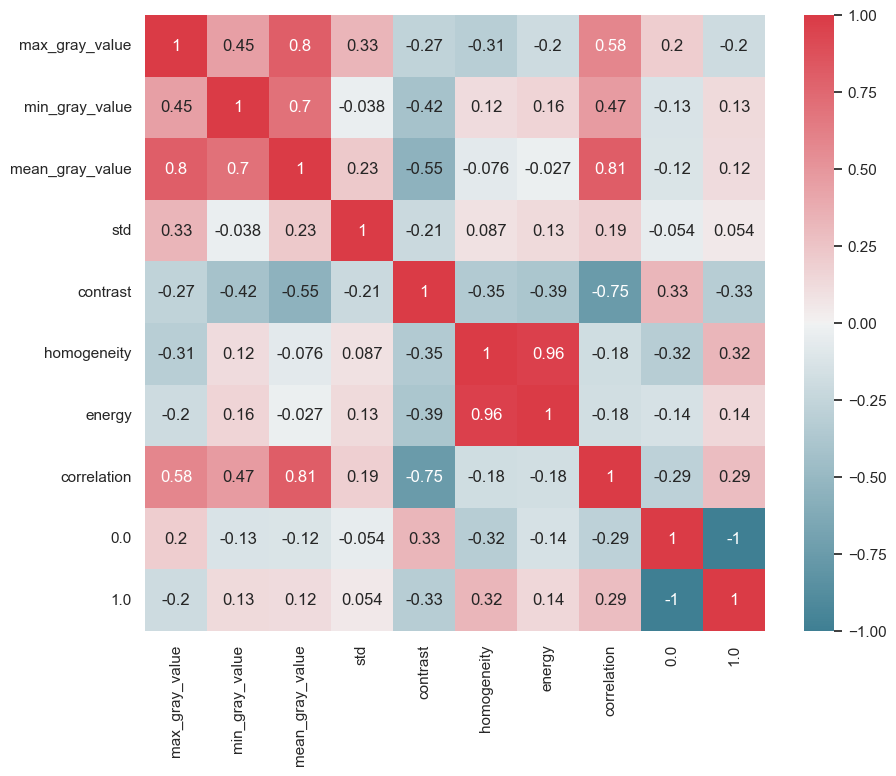

In [192]:
# Crear el mapa de calor

f, ax = plt.subplots(figsize=(10, 8))
corr = x.corr(method='spearman')
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax, annot=True)
plt.show() 

In [193]:
corr = corr_feature_detect(data=x,threshold=0.95)
for i in corr:
    print(i,'\n')
if len(corr) == 0:
    print('No hay variables correlacionadas')

      feature1 feature2      corr
0  homogeneity   energy  0.956982 



In [194]:
df_mangos_normalizado = df_mangos_normalizado.drop(columns=['energy'])

In [195]:
clase=pd.get_dummies(df_mangos_normalizado['clase'])
x=df_mangos_normalizado.drop('clase',axis=1) #Elimina la variable State de X, y se queda con las nuevas variables creadas por cada categoría
x=pd.concat([x,clase],axis=1)

print(x.head())

   max_gray_value  min_gray_value  mean_gray_value       std  contrast  \
0        0.264453        0.372536         0.444874  0.378915  0.042932   
1        0.303120        0.279960         0.366926  0.172785  0.036394   
2        0.295141        0.412105         0.508683  0.138042  0.127106   
3        0.175322        0.248359         0.270927  0.044431  0.504933   
4        0.126193        0.233440         0.272377  0.066600  0.385834   

   homogeneity  correlation    0.0   1.0  
0     0.844164     0.923142  False  True  
1     0.885325     0.894721  False  True  
2     0.537877     0.940063  False  True  
3     0.721466     0.528369  False  True  
4     0.888018     0.423304  False  True  


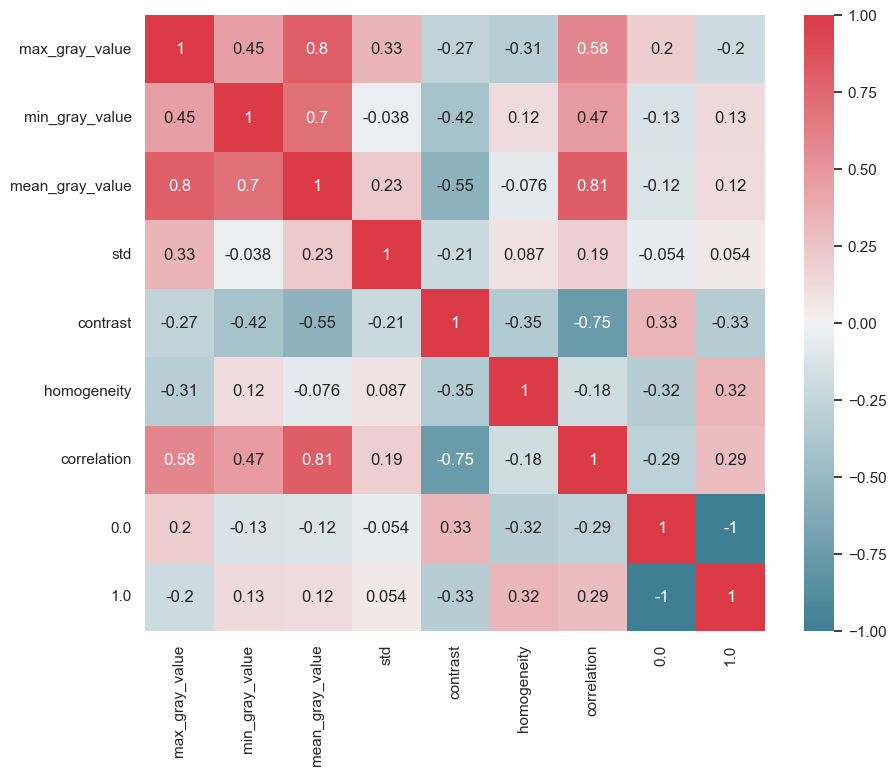

In [196]:
# Crear el mapa de calor

f, ax = plt.subplots(figsize=(10, 8))
corr = x.corr(method='spearman')
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax, annot=True)
plt.show() 

In [197]:
corr = corr_feature_detect(data=x,threshold=0.95)
for i in corr:
    print(i,'\n')
if len(corr) == 0:
    print('No hay variables correlacionadas')

No hay variables correlacionadas


In [198]:
#df_mangos_normalizado = df_mangos_normalizado.drop(columns=['max_gray_value'])
#df_mangos_normalizado = df_mangos_normalizado.drop(columns=['min_gray_value'])
df_mangos_normalizado = df_mangos_normalizado.drop(columns=['mean_gray_value'])
#df_mangos_normalizado = df_mangos_normalizado.drop(columns=['std'])
#df_mangos_normalizado = df_mangos_normalizado.drop(columns=['correlation'])

#### **Implementación de un modelo de predicción con regresión lineal**

In [224]:
df_mangos_combinado = df_mangos_combinado.drop(['area'], axis=1)

X = df_mangos_combinado.drop(['clase'], axis=1)
y = df_mangos_combinado['clase']

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [226]:
softReg = LogisticRegression( solver = 'lbfgs', penalty = None, max_iter=10000)
softReg.fit(X_train,y_train)

LogisticRegression(max_iter=10000, penalty=None)

In [227]:
y_train_predicted_softReg = softReg.predict(X_train)

print(" Matriz de confusion para los datos de entrenamiento:\n%s" % metrics.confusion_matrix(y_train, y_train_predicted_softReg))
print('Accuracy', accuracy_score(y_train, y_train_predicted_softReg))

 Matriz de confusion para los datos de entrenamiento:
[[235  45]
 [ 72 108]]
Accuracy 0.7456521739130435


In [228]:
y_test_predicted_softReg = softReg.predict(X_test)
print("Matriz de confusion para los datos de prueba:\n%s" % metrics.confusion_matrix(y_test, y_test_predicted_softReg))
print('Accuracy: ', accuracy_score(y_test, y_test_predicted_softReg))

Matriz de confusion para los datos de prueba:
[[100  22]
 [ 26  50]]
Accuracy:  0.7575757575757576


In [205]:
softReg_Lasso = LogisticRegression(solver = 'saga',  penalty = 'l1', C = 0.02, max_iter=3000)
softReg_Lasso.fit(X_train, y_train)

LogisticRegression(C=0.02, max_iter=3000, penalty='l1', solver='saga')

In [206]:
y_train_predicted_softReg_Lasso = softReg_Lasso.predict(X_train)
y_test_predicted_softReg_Lasso  = softReg_Lasso.predict(X_test)

print('Accuracy con los datos de entrenamiento: ', accuracy_score(y_train, y_train_predicted_softReg_Lasso))
print('Accuracy: con los datos de prueba', accuracy_score(y_test, y_test_predicted_softReg_Lasso))

Accuracy con los datos de entrenamiento:  0.6347826086956522
Accuracy: con los datos de prueba 0.5555555555555556


In [207]:
coefficients = softReg_Lasso.coef_
zero_features_across_classes = np.all(coefficients == 0, axis=0)
zeroed_feature_indices = np.where(zero_features_across_classes)[0]
print(zeroed_feature_indices)

[0 1 2 5]


#### **Implementación de un modelo de arboles de decicion**

In [229]:
y_target = df_mangos_combinado['clase']
x_data = df_mangos_combinado.drop(['clase'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size=0.20)

clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=20)
clf = clf.fit(x_train,y_train)

#Evaluación en el conjunto de prueba
y_pred = clf.predict(x_test)

print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf.score(x_test, y_test))) 
cmatrix = metrics.confusion_matrix(y_test, y_pred)
print(cmatrix)

print(classification_report(y_test, y_pred))
print(x_data.columns)

Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.90
[[71  6]
 [ 7 48]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        77
           1       0.89      0.87      0.88        55

    accuracy                           0.90       132
   macro avg       0.90      0.90      0.90       132
weighted avg       0.90      0.90      0.90       132

Index(['max_gray_value', 'min_gray_value', 'mean_gray_value', 'std',
       'contrast', 'homogeneity', 'correlation'],
      dtype='object')
